# Density Analysis: Extracting the Overdense Spine

Analyze the 3D UMAP embedding to identify and characterize the visible overdensity loop.

**Approach:**
1. Load 3D causal metric embedding and token indices
2. Compute kernel density estimation (KDE) in 3D
3. Extract high-density "spine" points
4. Fit a parametric curve through the spine
5. Map points back to token IDs and analyze vocabulary distribution

**Key questions:**
- What tokens live in the overdense loop vs. diffuse regions?
- Is there semantic structure (parts of speech, domains, topics)?
- What are the geometric properties (radius, thickness, curvature)?

**Inputs:**
- `data/vectors/umap_embedding_32k_3d_causal.npy` - 3D UMAP coordinates
- `data/vectors/distances_causal_32000.pt` - Token indices

**Outputs:**
- Density visualization
- Spine curve parameters
- Token vocabulary analysis

**Expected runtime:** ~2-3 minutes

## Configuration

In [1]:
# Input files
INPUT_EMBEDDING = '../data/vectors/umap_embedding_32k_3d_causal.npy'
DISTANCES_FILE = '../data/vectors/distances_causal_32000.pt'
MODEL_NAME = 'Qwen/Qwen3-4B-Instruct-2507'

# Analysis parameters
DENSITY_PERCENTILE = 75  # Threshold for "high density" points
KDE_BANDWIDTH = 0.3      # Kernel density estimation bandwidth

print(f"Configuration:")
print(f"  Input embedding: {INPUT_EMBEDDING}")
print(f"  Density threshold: {DENSITY_PERCENTILE}th percentile")
print(f"  KDE bandwidth: {KDE_BANDWIDTH}")

Configuration:
  Input embedding: ../data/vectors/umap_embedding_32k_3d_causal.npy
  Density threshold: 75th percentile
  KDE bandwidth: 0.3


## Setup

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import gaussian_kde
from scipy.interpolate import splprep, splev
from sklearn.cluster import DBSCAN
from transformers import AutoTokenizer

print("✓ Imports complete")

✓ Imports complete


## Load Data

In [3]:
print(f"Loading embedding from {INPUT_EMBEDDING}...")
embedding_3d = np.load(INPUT_EMBEDDING)

print(f"✓ Loaded embedding")
print(f"  Shape: {embedding_3d.shape}")
print(f"  X range: [{embedding_3d[:, 0].min():.2f}, {embedding_3d[:, 0].max():.2f}]")
print(f"  Y range: [{embedding_3d[:, 1].min():.2f}, {embedding_3d[:, 1].max():.2f}]")
print(f"  Z range: [{embedding_3d[:, 2].min():.2f}, {embedding_3d[:, 2].max():.2f}]")

print(f"\nLoading token indices from {DISTANCES_FILE}...")
data = torch.load(DISTANCES_FILE, weights_only=False)
token_indices = data['token_indices']

print(f"✓ Loaded token indices")
print(f"  N tokens: {len(token_indices):,}")

N = len(embedding_3d)
print(f"\n✓ Ready to analyze {N:,} tokens")

Loading embedding from ../data/vectors/umap_embedding_32k_3d_causal.npy...
✓ Loaded embedding
  Shape: (32000, 3)
  X range: [4.15, 9.74]
  Y range: [7.56, 12.25]
  Z range: [1.05, 6.24]

Loading token indices from ../data/vectors/distances_causal_32000.pt...
✓ Loaded token indices
  N tokens: 32,000

✓ Ready to analyze 32,000 tokens


## Compute Kernel Density Estimation

Use Gaussian KDE to estimate point density in 3D space.

In [4]:
print("\nComputing kernel density estimation...")
print(f"  This may take 1-2 minutes for {N:,} points...\n")

# Transpose for KDE (expects [n_features, n_samples])
xyz = embedding_3d.T  # [3, 32000]

# Compute KDE
kde = gaussian_kde(xyz, bw_method=KDE_BANDWIDTH)
density = kde(xyz)

print(f"✓ Computed density field")
print(f"  Min density: {density.min():.6f}")
print(f"  Max density: {density.max():.6f}")
print(f"  Mean density: {density.mean():.6f}")
print(f"  Median density: {np.median(density):.6f}")

# Compute threshold for "high density"
density_threshold = np.percentile(density, DENSITY_PERCENTILE)
print(f"\n  {DENSITY_PERCENTILE}th percentile: {density_threshold:.6f}")
print(f"  High-density points: {(density > density_threshold).sum():,}")


Computing kernel density estimation...
  This may take 1-2 minutes for 32,000 points...

✓ Computed density field
  Min density: 0.000614
  Max density: 0.107859
  Mean density: 0.032178
  Median density: 0.027052

  75th percentile: 0.034246
  High-density points: 8,000


## Visualize Density Field

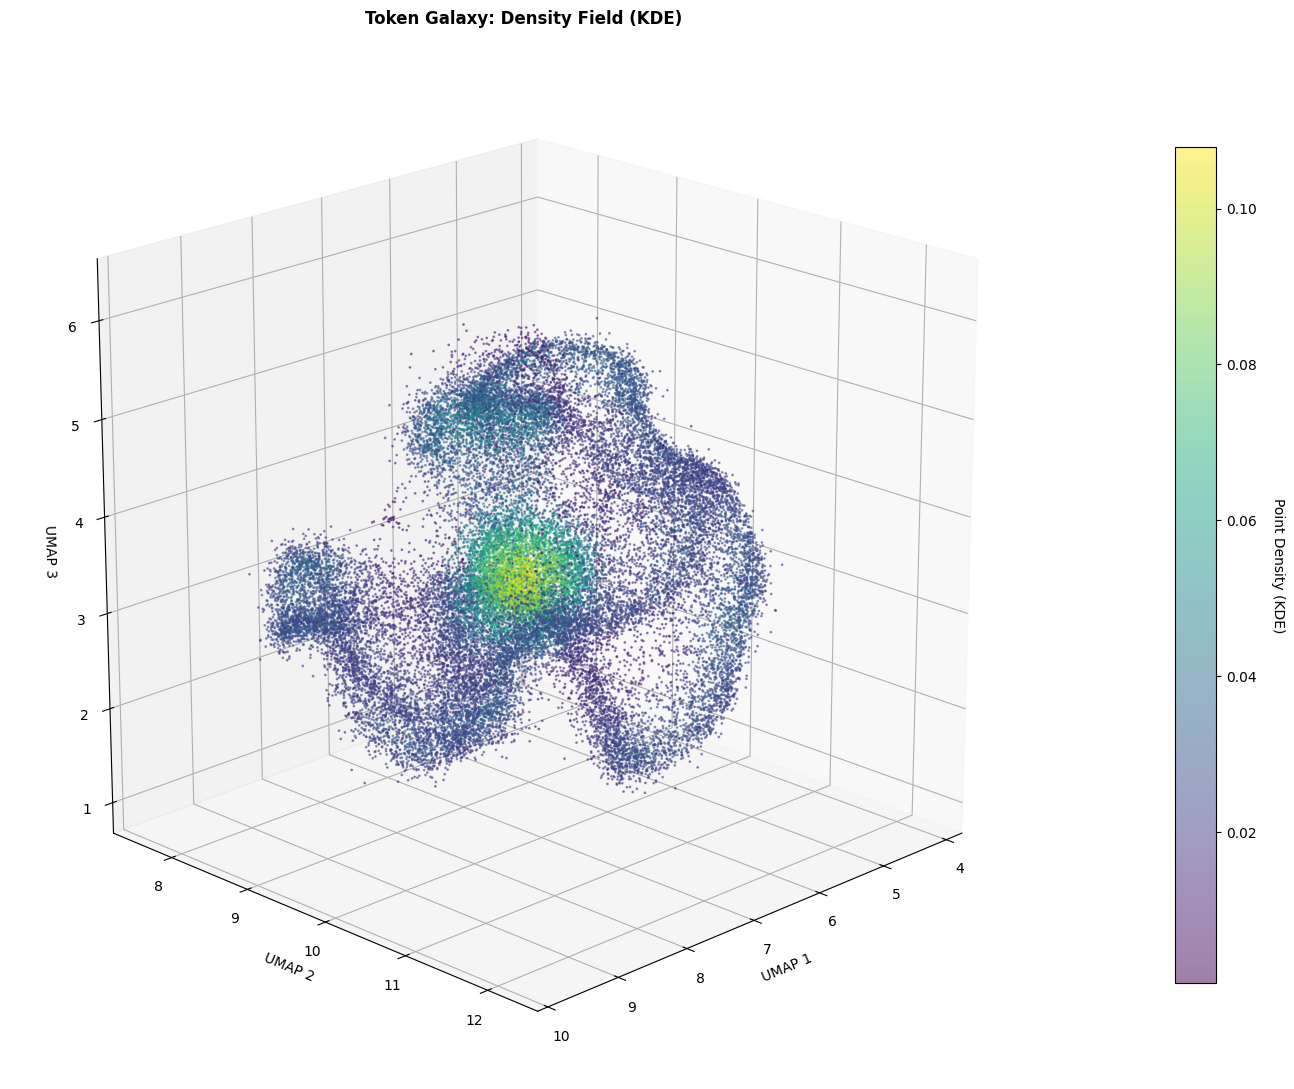


💡 Yellow = high density (overdense spine)
💡 Purple = low density (diffuse regions)


In [5]:
fig = plt.figure(figsize=(14, 11))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    embedding_3d[:, 0],
    embedding_3d[:, 1],
    embedding_3d[:, 2],
    c=density,
    cmap='viridis',
    s=1,
    alpha=0.5,
    rasterized=True
)

cbar = plt.colorbar(scatter, ax=ax, pad=0.1, shrink=0.8)
cbar.set_label('Point Density (KDE)', rotation=270, labelpad=20)

ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.set_zlabel('UMAP 3')
ax.set_title(f'Token Galaxy: Density Field (KDE)', pad=20, fontweight='bold')
ax.set_box_aspect([1, 1, 1])
ax.view_init(elev=20, azim=45)

plt.tight_layout()
plt.show()

print("\n💡 Yellow = high density (overdense spine)")
print("💡 Purple = low density (diffuse regions)")

## Density Distribution Analysis

Analyze the distribution of density values to identify distinct populations.

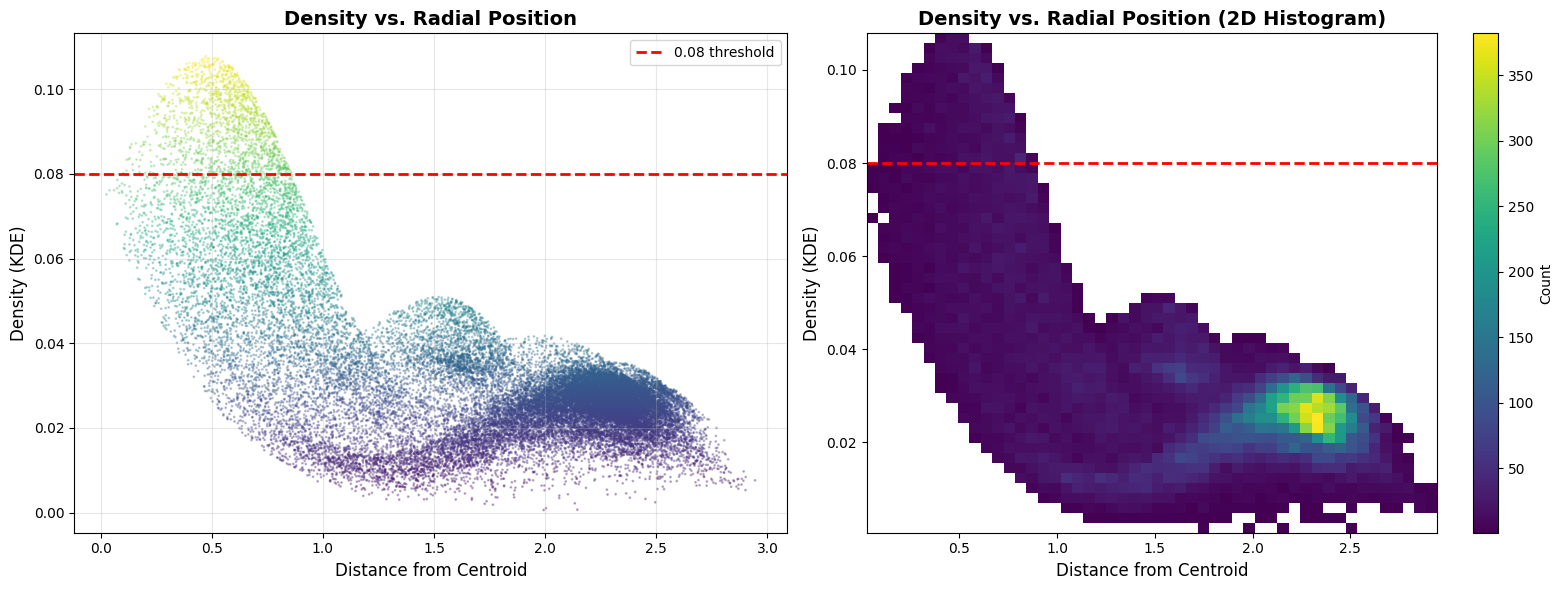


💡 Does high density correlate with distance from center?
  Correlation coefficient: -0.650


In [13]:
# Density vs. radius analysis
# Compute distance from centroid
centroid = embedding_3d.mean(axis=0)
radii = np.linalg.norm(embedding_3d - centroid, axis=1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot: density vs radius
ax1.scatter(radii, density, s=1, alpha=0.3, c=density, cmap='viridis', rasterized=True)
ax1.set_xlabel('Distance from Centroid', fontsize=12)
ax1.set_ylabel('Density (KDE)', fontsize=12)
ax1.set_title('Density vs. Radial Position', fontsize=14, fontweight='bold')
ax1.axhline(0.08, color='red', linestyle='--', linewidth=2, label='0.08 threshold')
ax1.grid(True, alpha=0.3)
ax1.legend()

# 2D histogram: density vs radius
h = ax2.hist2d(radii, density, bins=50, cmap='viridis', cmin=1)
ax2.set_xlabel('Distance from Centroid', fontsize=12)
ax2.set_ylabel('Density (KDE)', fontsize=12)
ax2.set_title('Density vs. Radial Position (2D Histogram)', fontsize=14, fontweight='bold')
ax2.axhline(0.08, color='red', linestyle='--', linewidth=2, label='0.08 threshold')
plt.colorbar(h[3], ax=ax2, label='Count')

plt.tight_layout()
plt.show()

print("\n💡 Does high density correlate with distance from center?")
print(f"  Correlation coefficient: {np.corrcoef(radii, density)[0, 1]:.3f}")

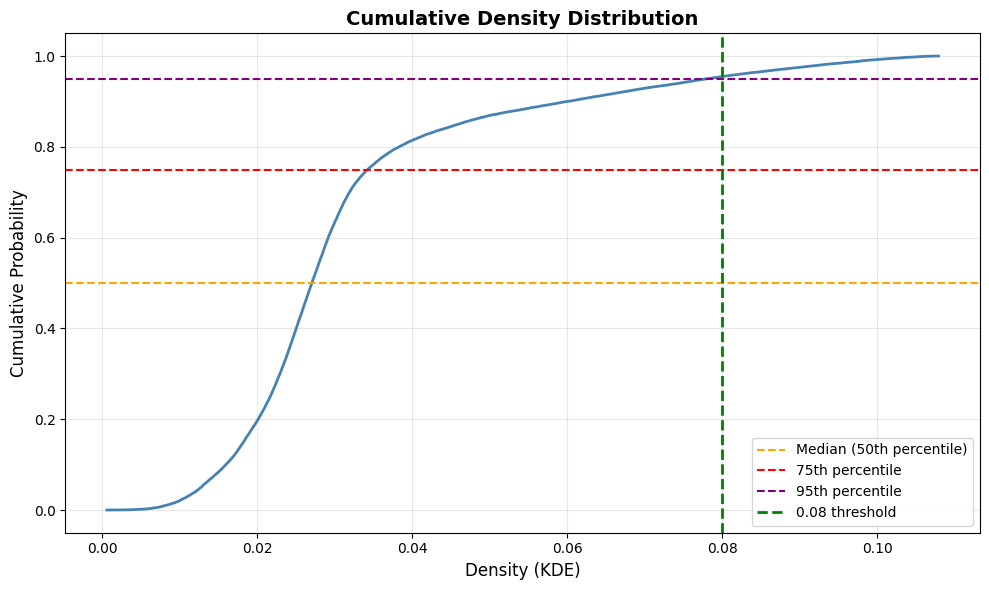


💡 Density > 0.08 is the top 95.46% (above 4.54th percentile)


In [14]:
# Cumulative distribution
fig, ax = plt.subplots(figsize=(10, 6))

sorted_density = np.sort(density)
cumulative = np.arange(1, len(sorted_density) + 1) / len(sorted_density)

ax.plot(sorted_density, cumulative, linewidth=2, color='steelblue')
ax.axhline(0.5, color='orange', linestyle='--', linewidth=1.5, label='Median (50th percentile)')
ax.axhline(0.75, color='red', linestyle='--', linewidth=1.5, label='75th percentile')
ax.axhline(0.95, color='purple', linestyle='--', linewidth=1.5, label='95th percentile')
ax.axvline(0.08, color='green', linestyle='--', linewidth=2, label='0.08 threshold')

ax.set_xlabel('Density (KDE)', fontsize=12)
ax.set_ylabel('Cumulative Probability', fontsize=12)
ax.set_title('Cumulative Density Distribution', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

# Find what percentile 0.08 corresponds to
percentile_08 = 100 * (density > 0.08).sum() / len(density)
print(f"\n💡 Density > 0.08 is the top {100 - percentile_08:.2f}% (above {percentile_08:.2f}th percentile)")

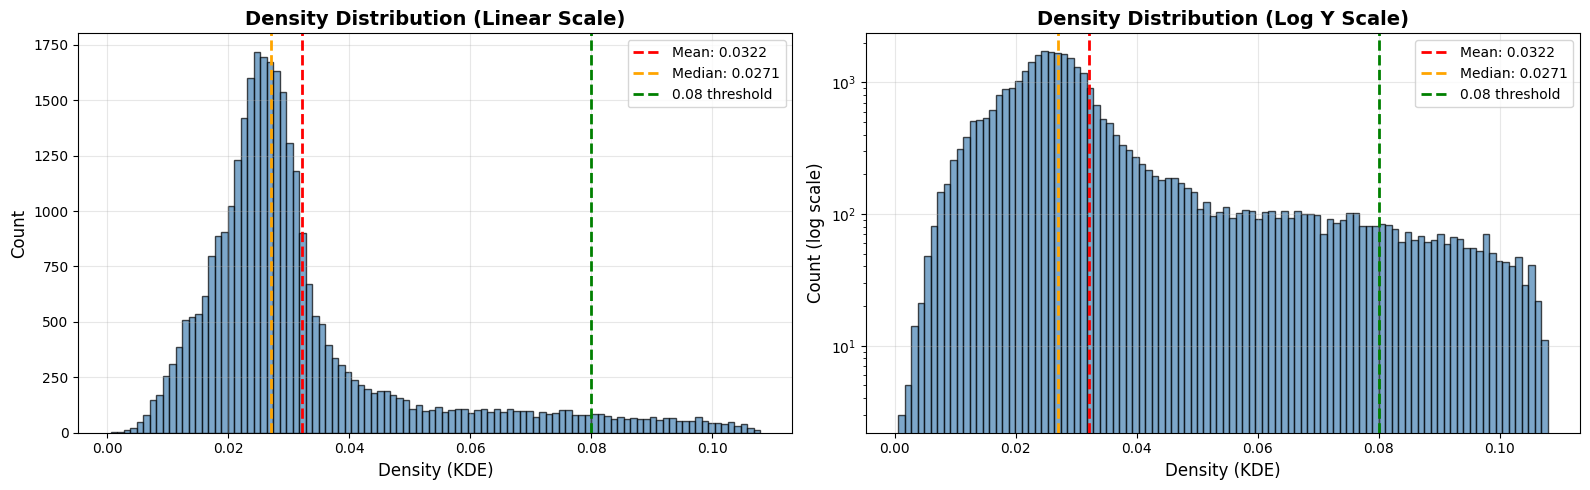


💡 Linear scale shows overall shape
💡 Log scale reveals structure in rare high-density tail


In [15]:
# Linear histogram
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Linear-linear
ax1.hist(density, bins=100, color='steelblue', alpha=0.7, edgecolor='black')
ax1.axvline(density.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {density.mean():.4f}')
ax1.axvline(np.median(density), color='orange', linestyle='--', linewidth=2, label=f'Median: {np.median(density):.4f}')
ax1.axvline(0.08, color='green', linestyle='--', linewidth=2, label='0.08 threshold')
ax1.set_xlabel('Density (KDE)', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title('Density Distribution (Linear Scale)', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Linear-log (log y-axis)
ax2.hist(density, bins=100, color='steelblue', alpha=0.7, edgecolor='black')
ax2.axvline(density.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {density.mean():.4f}')
ax2.axvline(np.median(density), color='orange', linestyle='--', linewidth=2, label=f'Median: {np.median(density):.4f}')
ax2.axvline(0.08, color='green', linestyle='--', linewidth=2, label='0.08 threshold')
ax2.set_xlabel('Density (KDE)', fontsize=12)
ax2.set_ylabel('Count (log scale)', fontsize=12)
ax2.set_title('Density Distribution (Log Y Scale)', fontsize=14, fontweight='bold')
ax2.set_yscale('log')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Linear scale shows overall shape")
print("💡 Log scale reveals structure in rare high-density tail")

In [16]:
print("\nDensity distribution statistics:")
print(f"  Range: [{density.min():.6f}, {density.max():.6f}]")
print(f"  Mean: {density.mean():.6f}")
print(f"  Median: {np.median(density):.6f}")
print(f"  Std: {density.std():.6f}")
print(f"  CV: {100 * density.std() / density.mean():.1f}%")

# Key percentiles
percentiles = [25, 50, 75, 90, 95, 99]
print(f"\nKey percentiles:")
for p in percentiles:
    val = np.percentile(density, p)
    print(f"  {p:2d}th: {val:.6f}")

# Look for the ~0.08 region you mentioned
n_above_08 = (density > 0.08).sum()
print(f"\nPoints with density > 0.08: {n_above_08:,} ({100*n_above_08/N:.2f}%)")


Density distribution statistics:
  Range: [0.000614, 0.107859]
  Mean: 0.032178
  Median: 0.027052
  Std: 0.018777
  CV: 58.4%

Key percentiles:
  25th: 0.021688
  50th: 0.027052
  75th: 0.034246
  90th: 0.060042
  95th: 0.078063
  99th: 0.098368

Points with density > 0.08: 1,453 (4.54%)
